In [1]:
from scipy import linalg
import matplotlib
import numpy as np

## Isotonic Regression

In [2]:
def isotonic_regression(y, weight=None, y_min=None, y_max=None, callback=None):
    """Solve the isotonic regression model::

        min sum w[i] (y[i] - y_[i]) ** 2

        subject to y_min = y_[1] <= y_[2] ... <= y_[n] = y_max

    where:
        - y[i] are inputs (real numbers)
        - y_[i] are fitted
        - w[i] are optional strictly positive weights (default to 1.0)

    Parameters
    ----------
    y : iterable of floating-point values
        The data.

    weight : iterable of floating-point values, optional, default: None
        Weights on each point of the regression.
        If None, weight is set to 1 (equal weights).

    y_min : optional, default: None
        If not None, set the lowest value of the fit to y_min.

    y_max : optional, default: None
        If not None, set the highest value of the fit to y_max.

    Returns
    -------
    `y_` : list of floating-point values
        Isotonic fit of y.

    References
    ----------
    "Active set algorithms for isotonic regression; A unifying framework"
    by Michael J. Best and Nilotpal Chakravarti, section 3.
    """
    if weight is None:
        weight = np.ones(len(y), dtype=y.dtype)
    if y_min is not None or y_max is not None:
        y = np.copy(y)
        weight = np.copy(weight)
        C = np.dot(weight, y * y) * 10  # upper bound on the cost function
        if y_min is not None:
            y[0] = y_min
            weight[0] = C
        if y_max is not None:
            y[-1] = y_max
            weight[-1] = C

    active_set = [(weight[i] * y[i], weight[i], [i, ])
                  for i in range(len(y))]
    current = 0
    counter = 0
    while current < len(active_set) - 1:
        value0, value1, value2 = 0, 0, np.inf
        weight0, weight1, weight2 = 1, 1, 1
        while value0 * weight1 <= value1 * weight0 and \
                        current < len(active_set) - 1:
            value0, weight0, idx0 = active_set[current]
            value1, weight1, idx1 = active_set[current + 1]
            if value0 * weight1 <= value1 * weight0:
                current += 1

            if callback is not None:
                callback(y, active_set, counter, idx1)
                counter += 1

        if current == len(active_set) - 1:
            break

        # merge two groups
        value0, weight0, idx0 = active_set.pop(current)
        value1, weight1, idx1 = active_set.pop(current)
        active_set.insert(current,
                          (value0 + value1,
                           weight0 + weight1, idx0 + idx1))
        while value2 * weight0 > value0 * weight2 and current > 0:
            value0, weight0, idx0 = active_set[current]
            value2, weight2, idx2 = active_set[current - 1]
            if weight0 * value2 >= weight2 * value0:
                active_set.pop(current)
                active_set[current - 1] = (value0 + value2, weight0 + weight2,
                                           idx0 + idx2)
                current -= 1

    solution = np.empty(len(y))
    if callback is not None:
        callback(y, active_set, counter+1, idx1)
        callback(y, active_set, counter+2, idx1)
    for value, weight, idx in active_set:
        solution[idx] = value / weight
    return solution

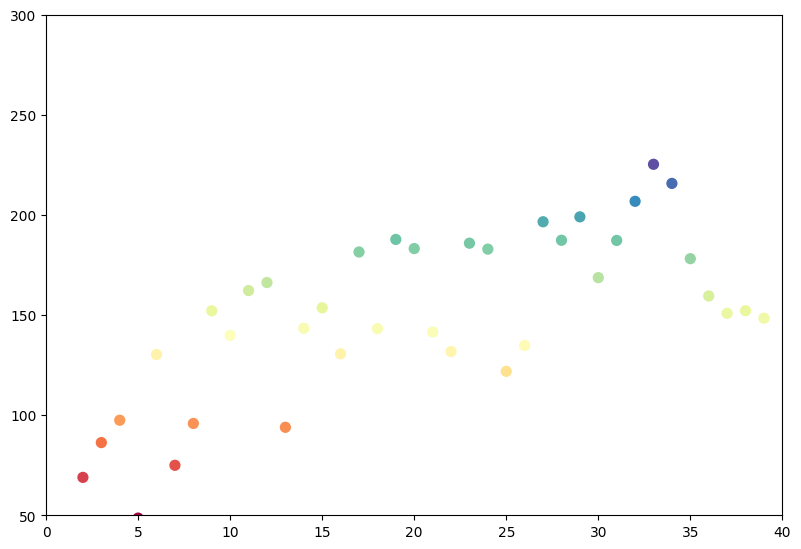

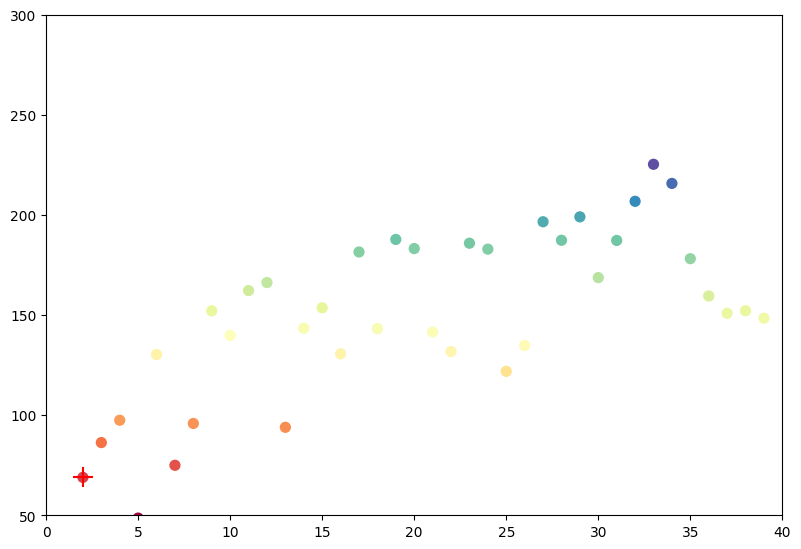

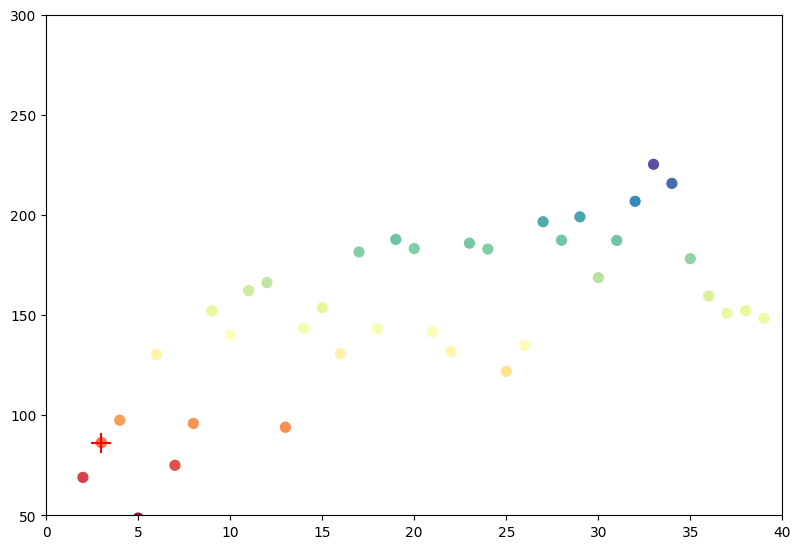

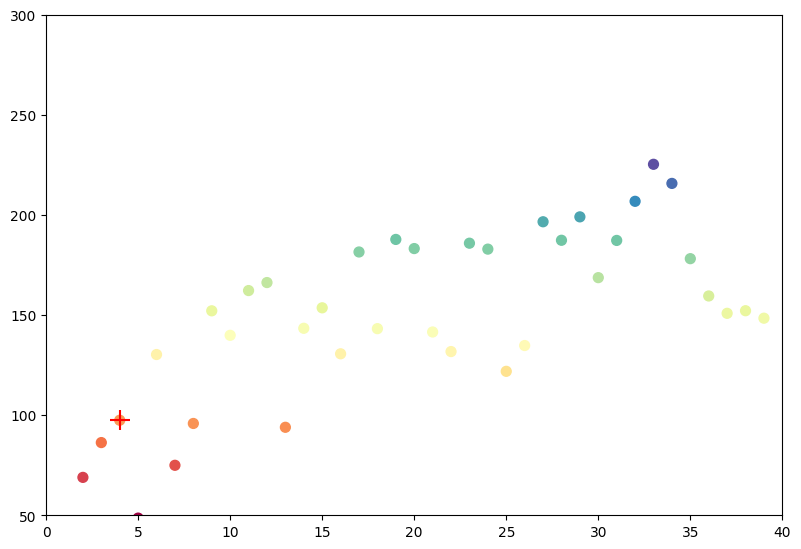

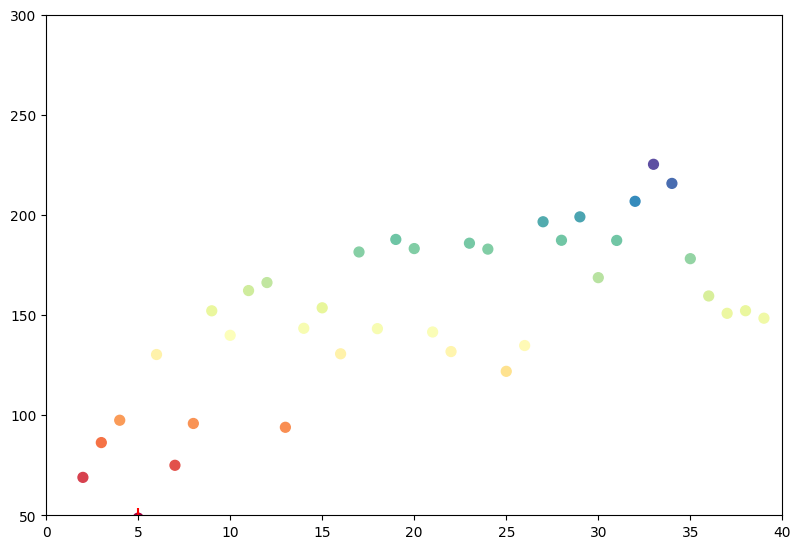

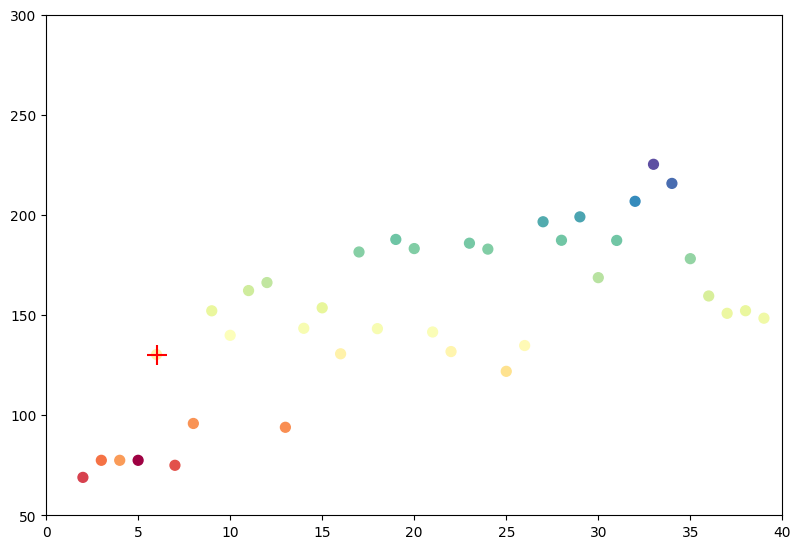

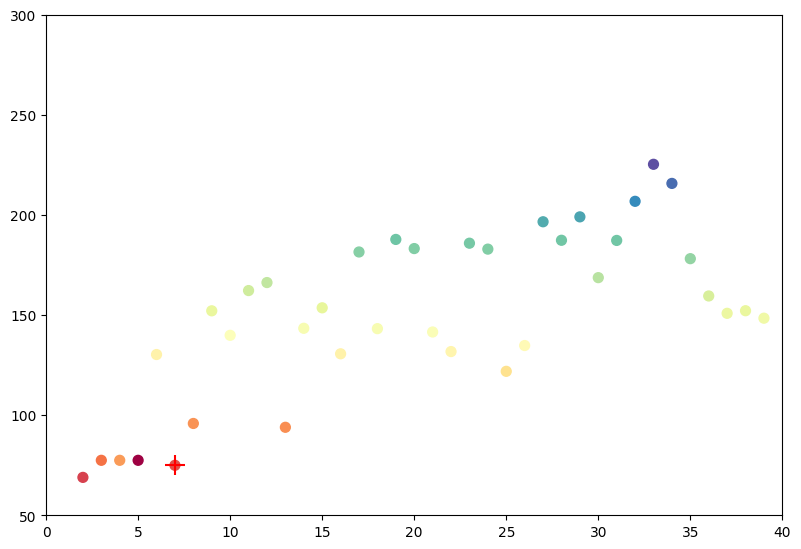

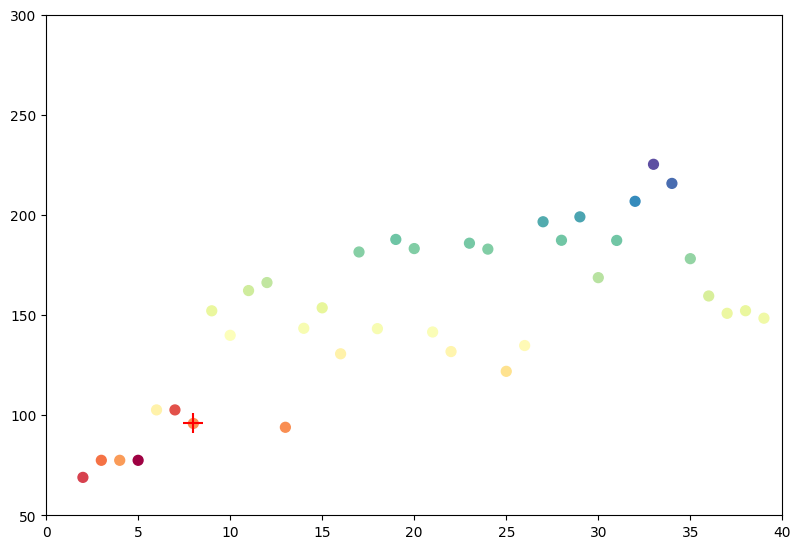

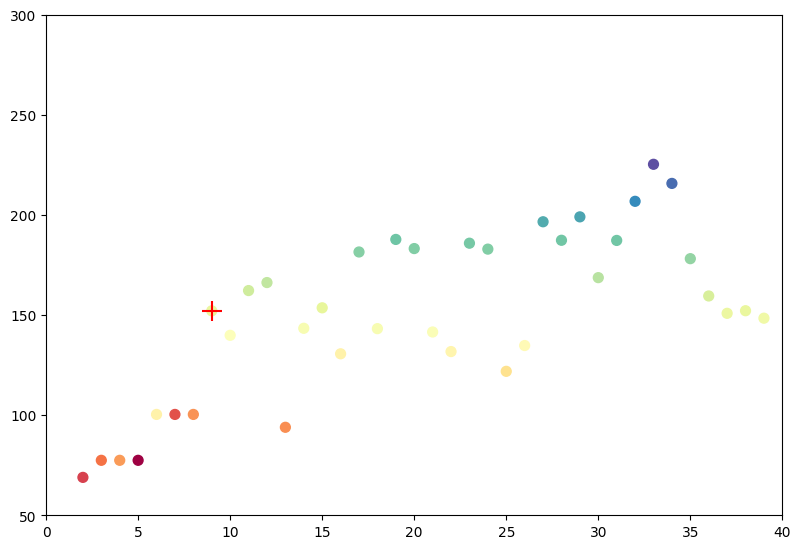

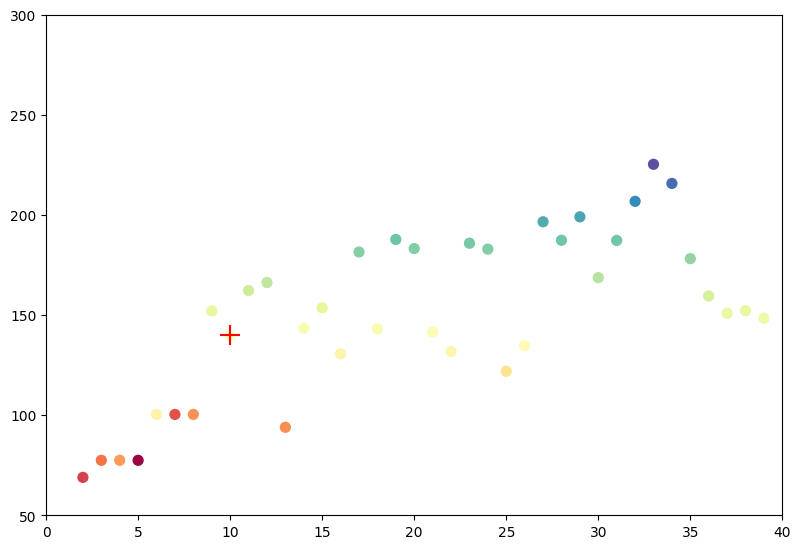

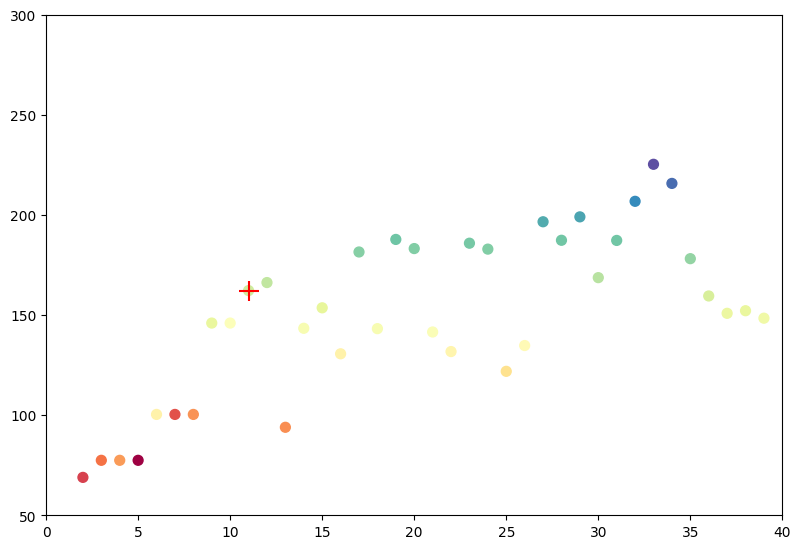

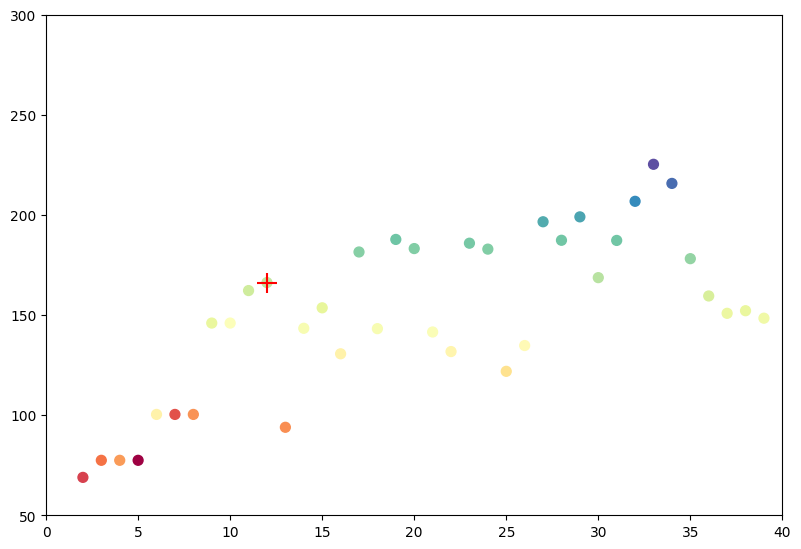

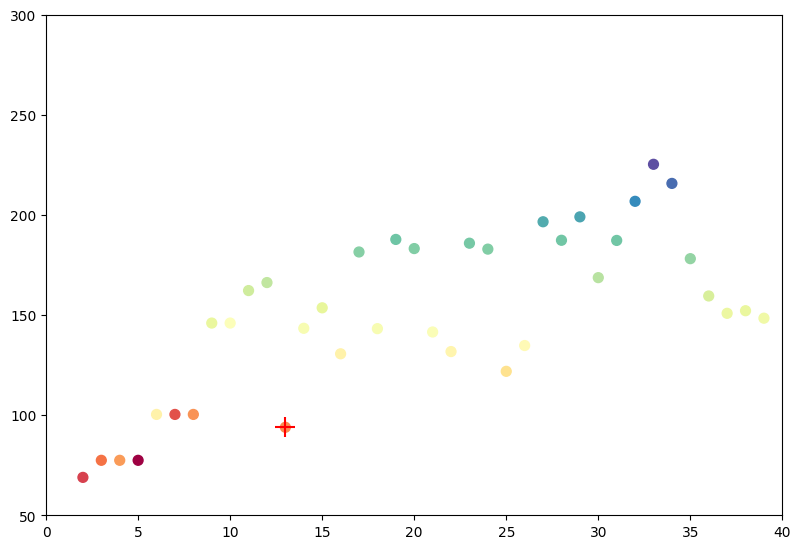

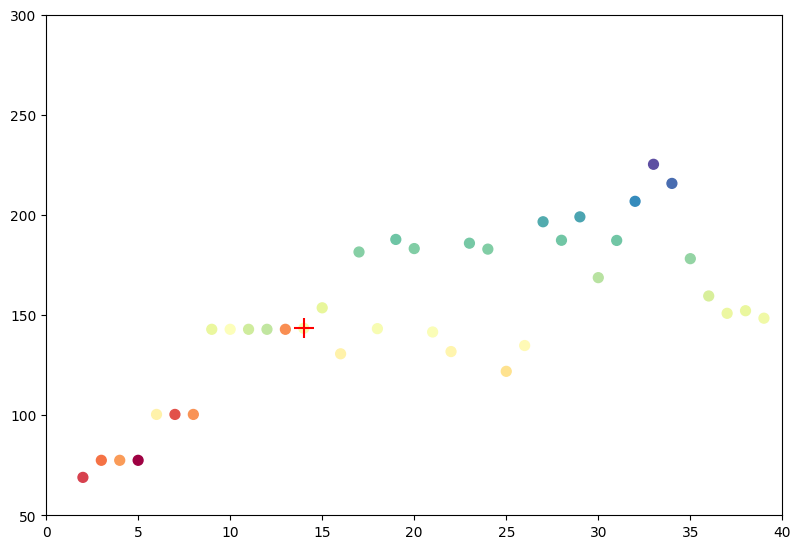

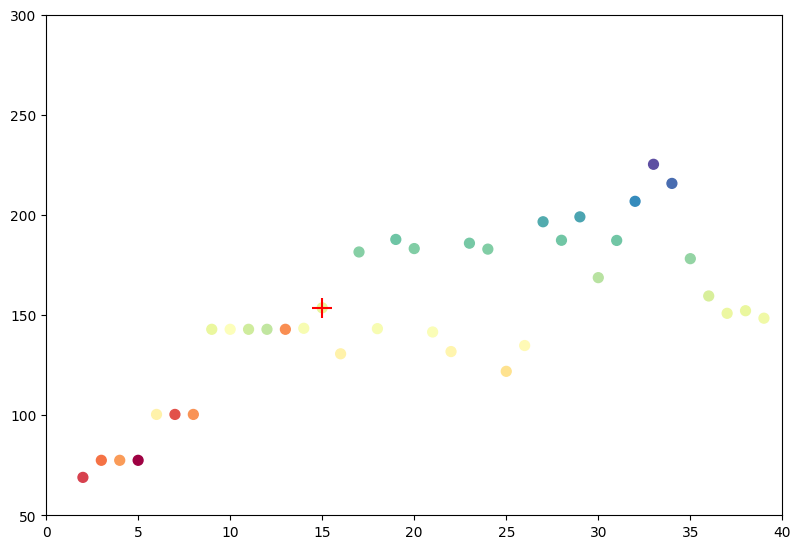

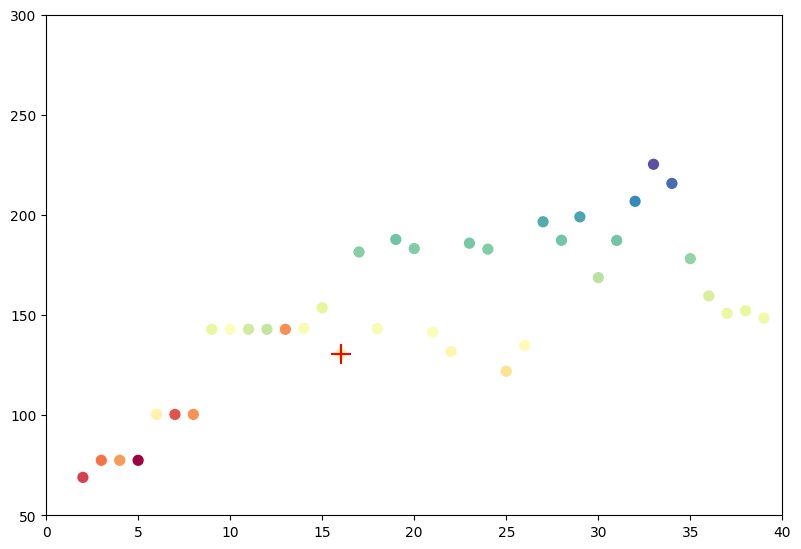

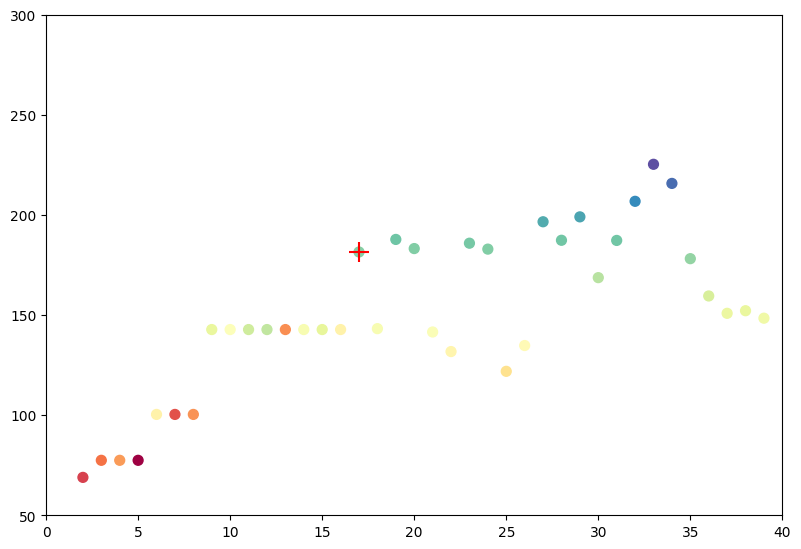

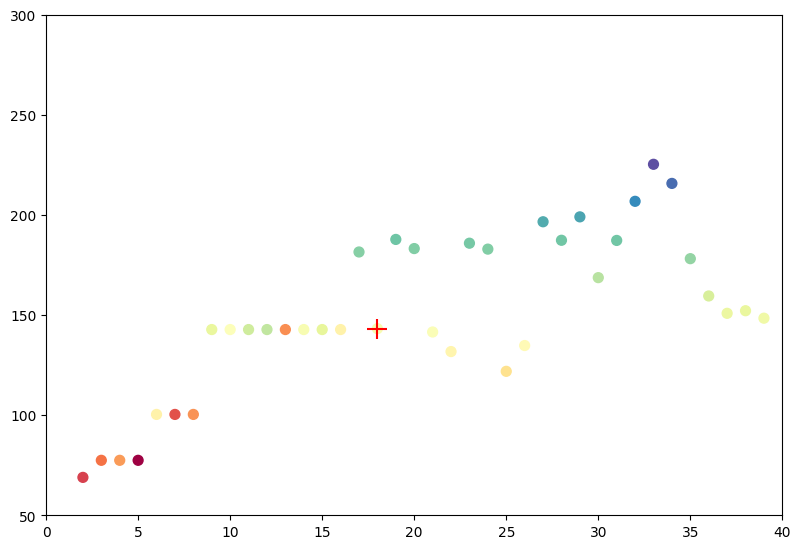

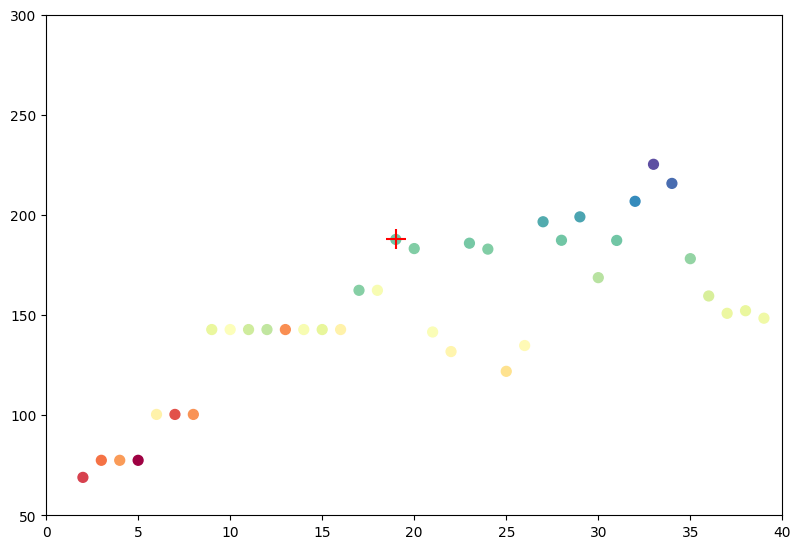

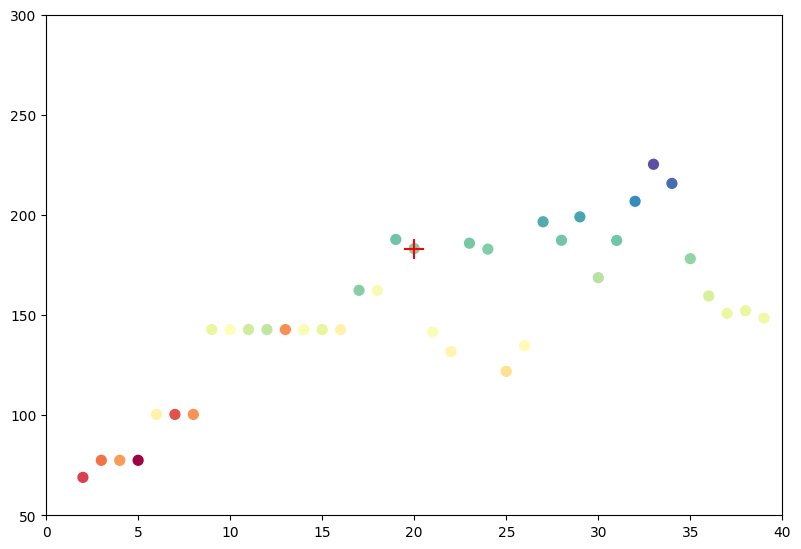

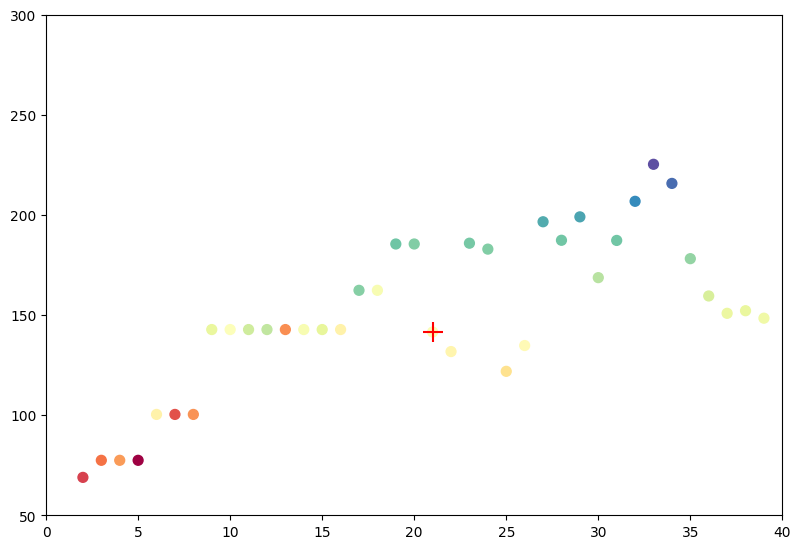

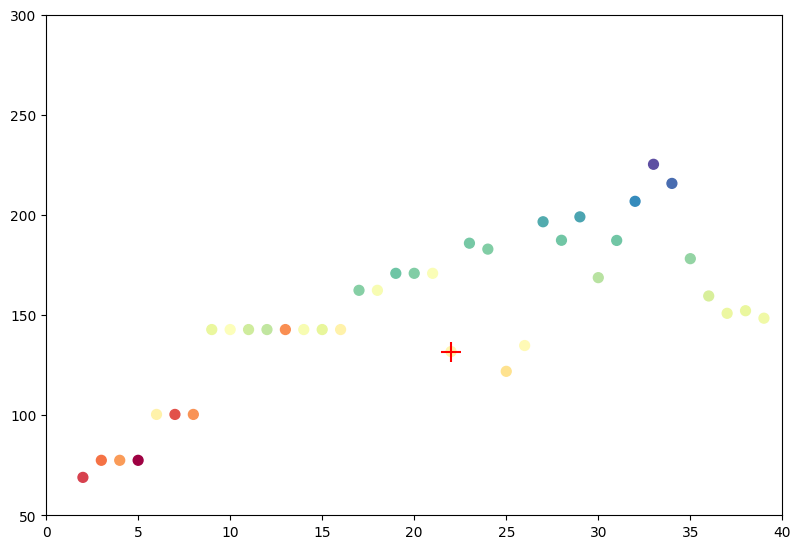

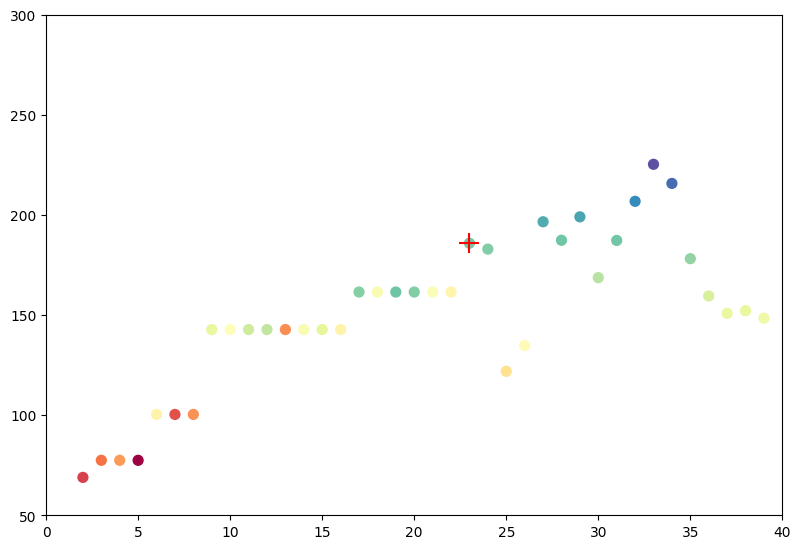

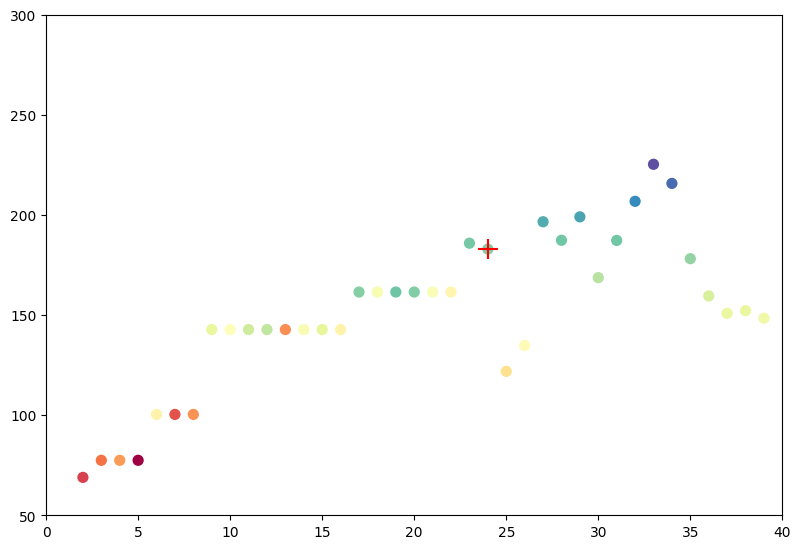

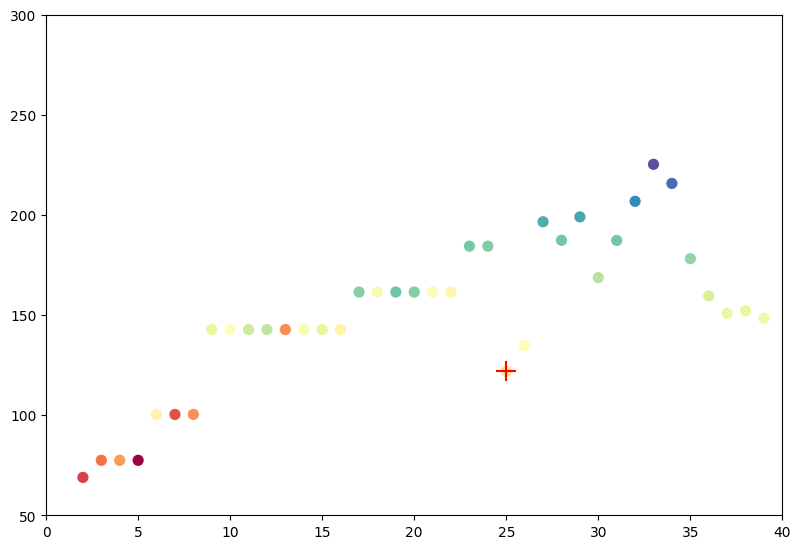

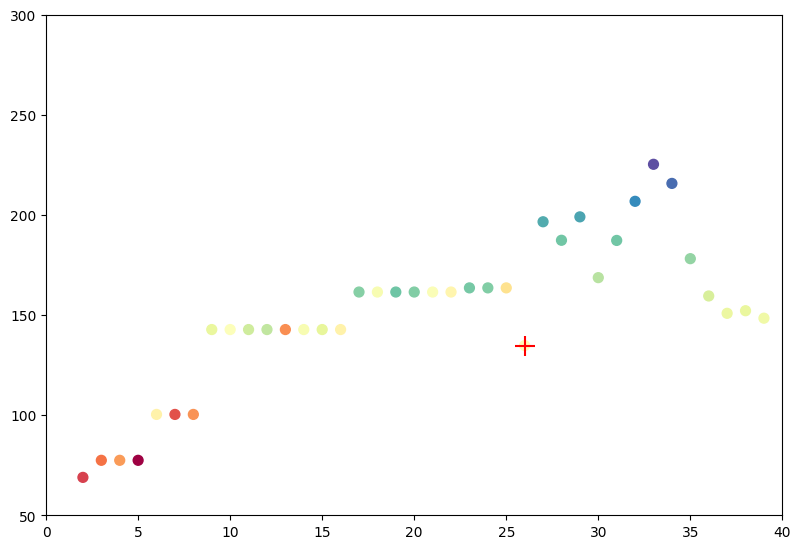

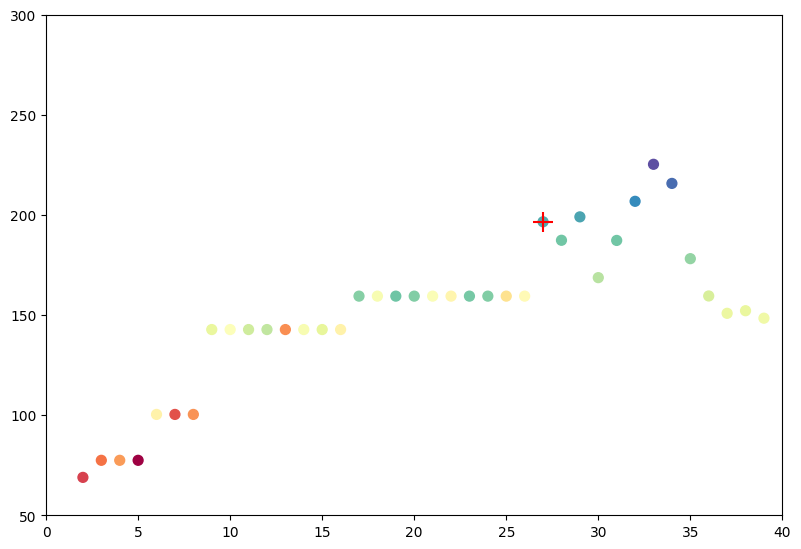

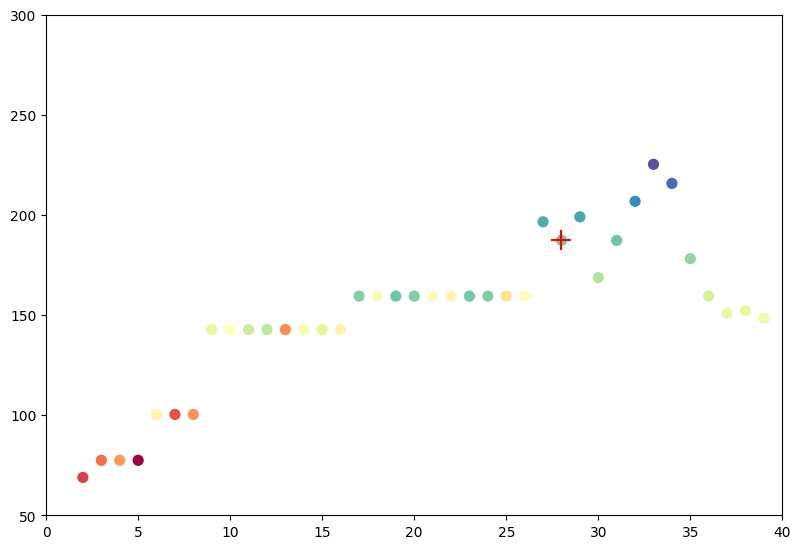

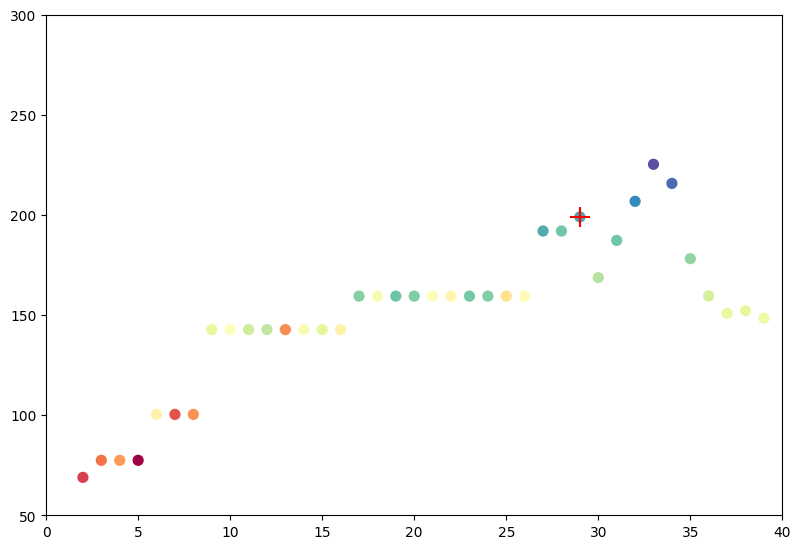

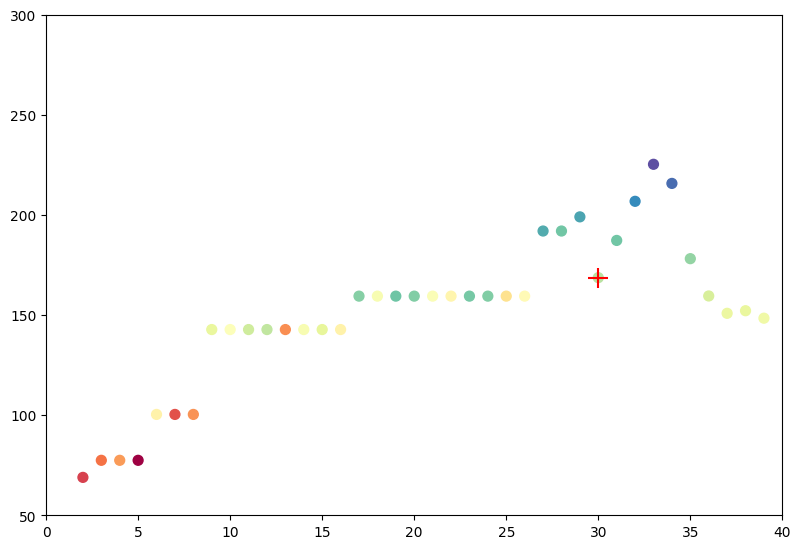

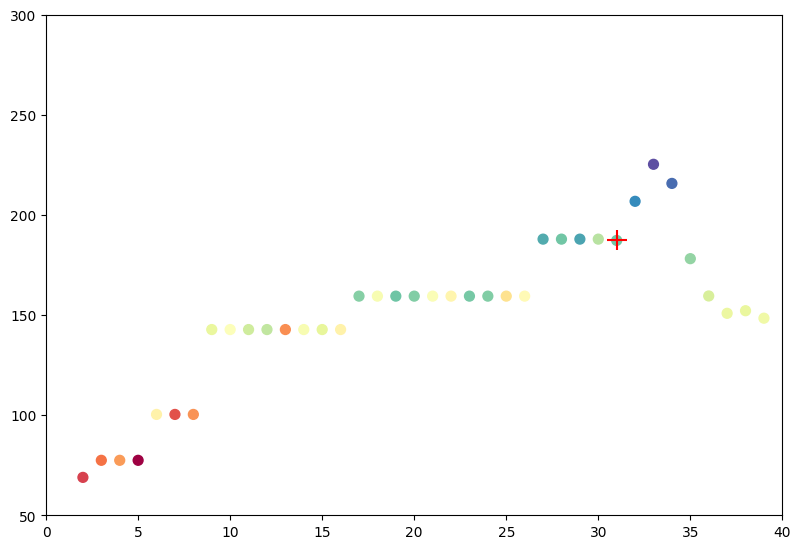

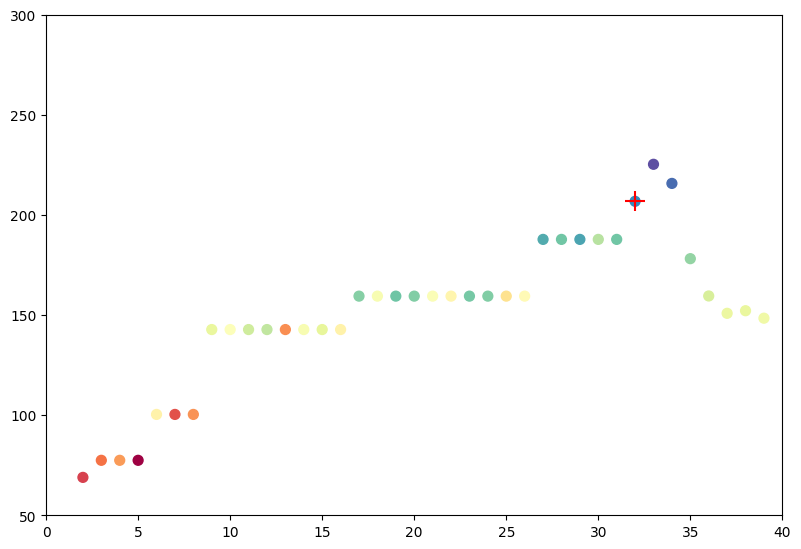

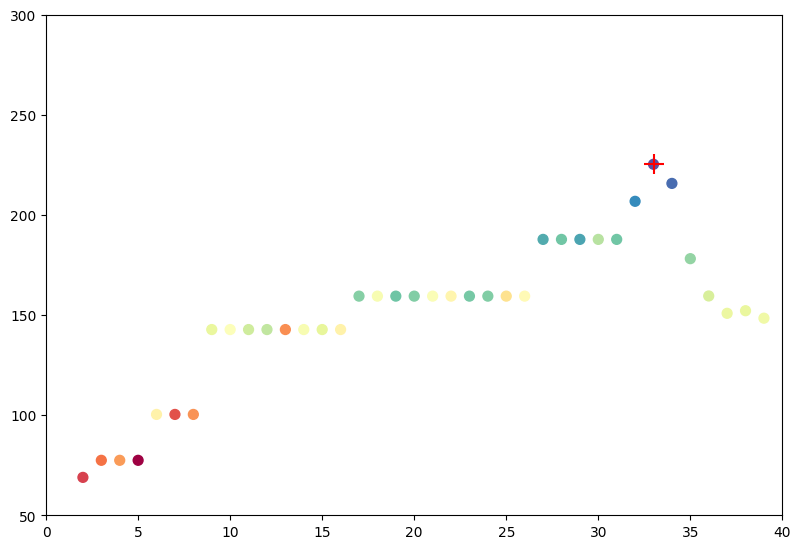

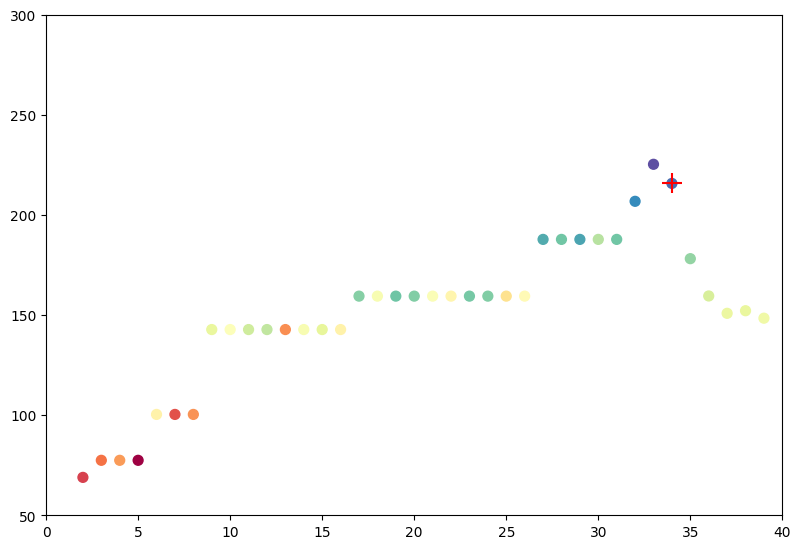

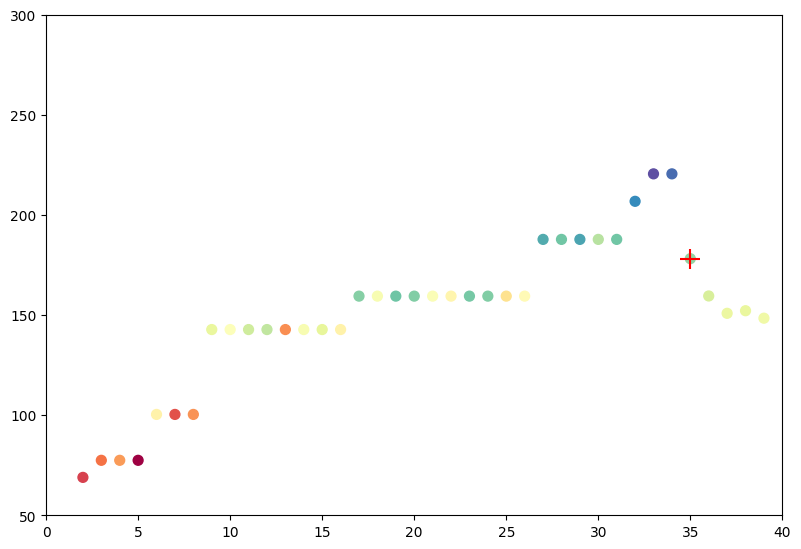

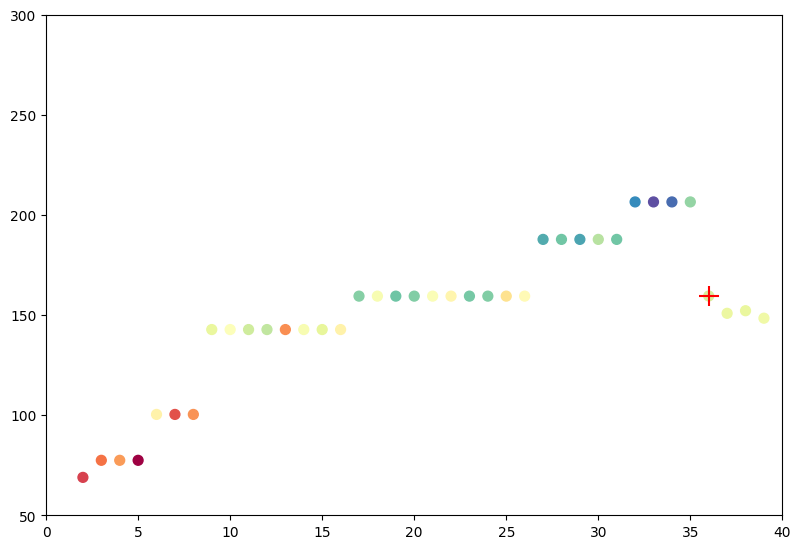

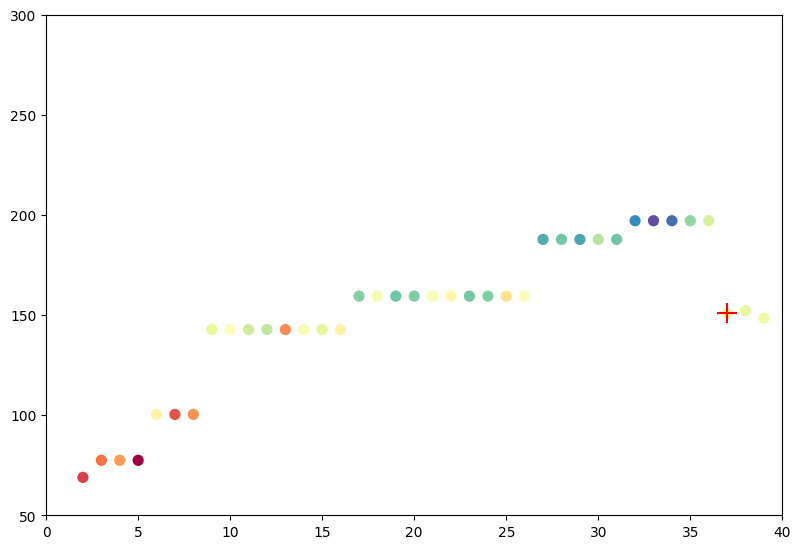

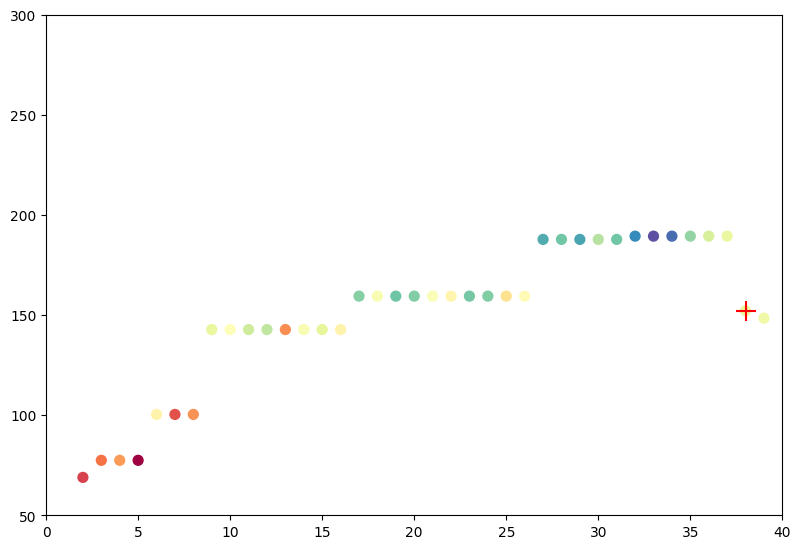

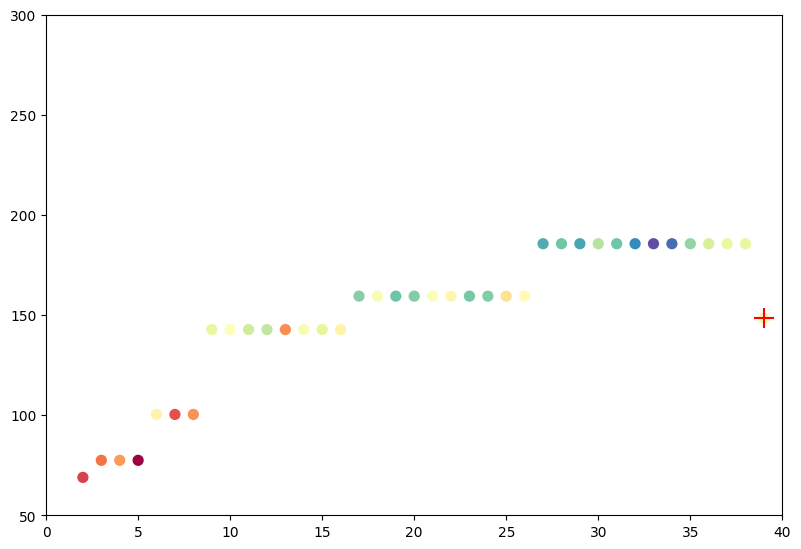

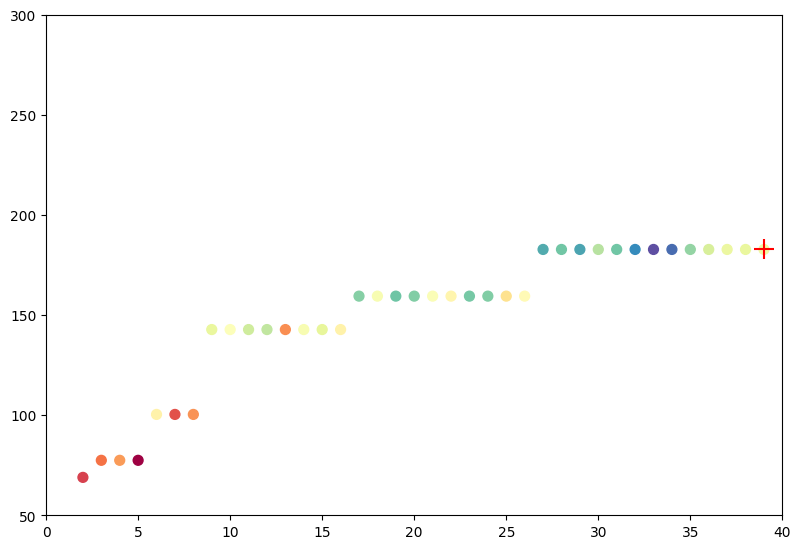

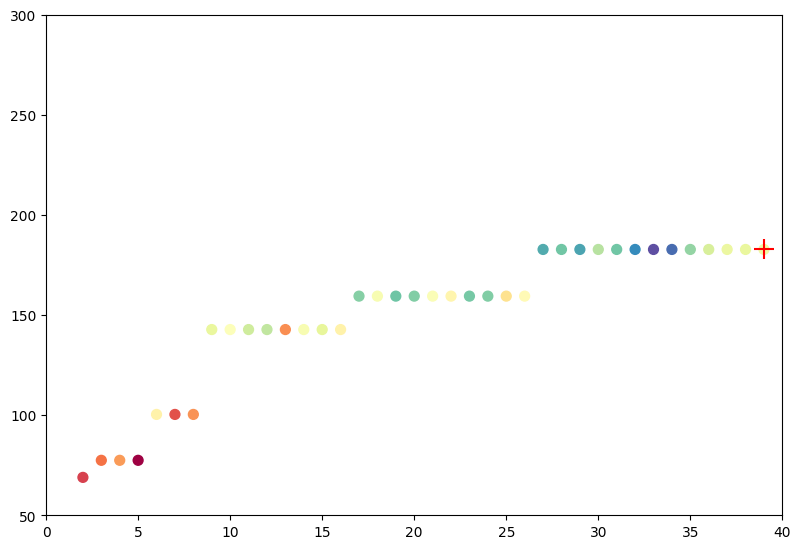

In [4]:
import numpy as np
import pylab as pl
from matplotlib.collections import LineCollection

from sklearn.linear_model import LinearRegression
from sklearn.isotonic import IsotonicRegression
from sklearn.utils import check_random_state


def cb(y, active_set, counter, current):
    solution = np.empty(len(y))
    for value, weight, idx in active_set:
        solution[idx] = value / weight
    fig = matplotlib.pyplot.gcf()
    fig.set_size_inches(9.5,6.5)

    color = y.copy()
    pl.scatter(np.arange(len(y)), solution, s=50, cmap=pl.cm.Spectral, vmin=50, c=color)
    pl.scatter([np.arange(len(y))[current]], [solution[current]], s=200, marker='+', color='red')
    pl.xlim((0, 40))
    pl.ylim((50, 300))
    #pl.savefig('isotonic_%03d.png' % counter)
    pl.show()

n = 40
x = np.arange(n)
rs = check_random_state(0)
y = rs.randint(-50, 50, size=(n,)) + 50. * np.log(1 + np.arange(n))

###############################################################################
# Fit IsotonicRegression and LinearRegression models


y_ = isotonic_regression(y, callback=cb)

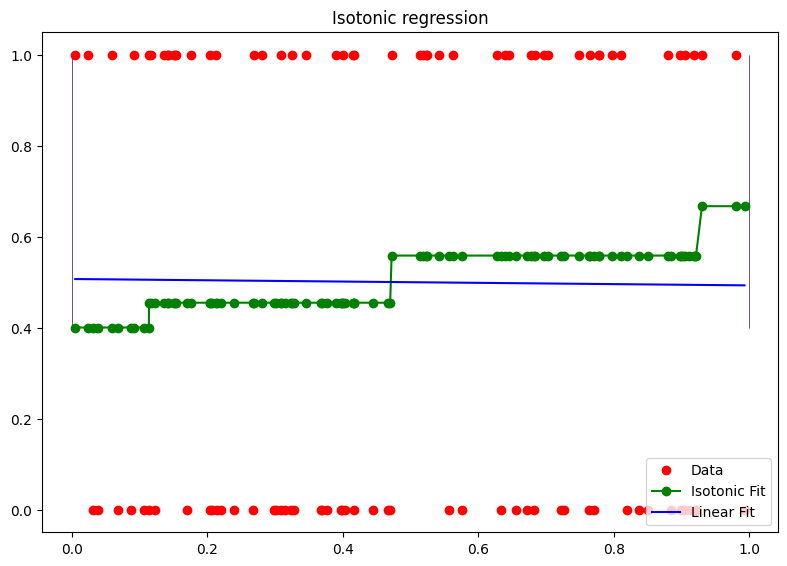

In [5]:
import pylab as pl
from matplotlib.collections import LineCollection

from sklearn.linear_model import LinearRegression
from sklearn.isotonic import IsotonicRegression
from sklearn.utils import check_random_state

n = 100
y = np.array([0]*50+[1]*50)
rs = check_random_state(0)
x = np.random.random(size=(n,)) #you can interpret it as the outputs of the SVM or any other model

res = sorted(list(zip(x,y)), key = lambda x: x[0]) 
x = []
y = []
for i,j in res:
    x.append(i)
    y.append(j)
x= np.array(x)
y= np.array(y)
###############################################################################
# Fit IsotonicRegression and LinearRegression models

ir = IsotonicRegression()
y_ = ir.fit_transform(x, y)

lr = LinearRegression()
lr.fit(x[:, np.newaxis], y)  # x needs to be 2d for LinearRegression

###############################################################################
# plot result

segments = [[[i, y[i]], [i, y_[i]]] for i in range(n)]
lc = LineCollection(segments, zorder=0)
lc.set_array(np.ones(len(y)))
lc.set_linewidths(0.5 * np.ones(n))

fig = pl.figure()
pl.plot(x, y, 'r.', markersize=12)
pl.plot(x, y_, 'g.-', markersize=12)
pl.plot(x, lr.predict(x[:, np.newaxis]), 'b-')
pl.gca().add_collection(lc)
pl.legend(('Data', 'Isotonic Fit', 'Linear Fit'), loc='lower right')
pl.title('Isotonic regression')

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(9.5,6.5)
pl.savefig('inverse_isotonic.png')
pl.show()